<a href="https://colab.research.google.com/github/ming80302/Innovator/blob/main/ts_ana_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import calendar
import numpy as np
import xarray as xr
import pandas as pd
#import os
import matplotlib.pyplot as plt 
from datetime import timedelta, date

Timeserie analysis of  of 3 locations from Origon (Washingto, Multnomah, Clackamas)

In [88]:

def rd_ts(dir_i, var_s, is_F):
    '''
    is_F: True- Convert Celsius to Fahrenheit
          False - keep the units
    '''  
    flnm = dir_i + var_s + "_1981-2021.csv"
    print('read ', flnm)
 
    df = pd.read_csv(flnm)

    # convert date column to DateTime
    df['date'] = pd.to_datetime(df.date)

    if is_F :
       df['Washington']=df['Washington']*9.0/5.0 + 32.0
       df['Multnomah']=df['Multnomah']*9.0/5.0 + 32.0
       df['Clackamas']=df['Clackamas']*9.0/5.0 + 32.0   

    # note: convert index to DatetimeIndex so I can use groupby year later on
    df.index =  pd.to_datetime(df.date)
    
    return df

def plot_trend(df, ax):
    '''
    add a trend line to dataframe plot
    '''
     
    z1 = np.polyfit(df.index, df.Washington, 1)
    z2 = np.polyfit(df.index, df.Multnomah, 1)
    z3 = np.polyfit(df.index, df.Clackamas, 1)
    
    p1 = np.poly1d(z1)
    p2 = np.poly1d(z2)
    p3 = np.poly1d(z3)

    ax.yaxis.set_ticks_position('both')
    ax.plot(df.index, p1(df.index), color='blue')
    ax.plot(df.index, p2(df.index), color='orange')
    ax.plot(df.index, p3(df.index), color='green')     

def df_n_quantile(df, df_year, p_quantile, is_exceed):
    '''
    df:
    df_year: DataFrame of number of days > or < p_quantile
             of 3 variables 
    p_quantile: quantile 0-1
    is_exceed: 
        True > p_quantile
        False < p_quantile
    '''
    
    name_col = df.columns
    n_loc = 3
    p_qtile = df.quantile(p_value)  
    if p_quantile == 0.0:
        p_qtile[:] = 0.1
        
    ## note: quantile works on all 4 number columns
    #print("quantile:")
    #print(p_qtile)
    #print("")

    for count in range(0, n_loc):
        #print("works on", name_col[count+3])
        
        if is_exceed:
            obj_p = df.loc[:, name_col[count+3]] > p_qtile[count+1] 
        else:
            obj_p = df.loc[:, name_col[count+3]] < p_qtile[count+1] 
     
        # Boolean indexing  obj_p[obj_p]
        # number of true for each year obj.groupby(lambda x: x.year).size()
        # x means df.index 'datetime' we converted to
        # groupby(lambda x: x.year).size()
        # equivalent to:
        # def func(date):
        #     return date.year
        # df.groupby(func).size()

        ser_0 = obj_p[obj_p].groupby(lambda x: x.year).size()
     
        for year in range(df.year[0], df.year[-1]+1, 1):
            try:
            # get a list of columns: list(df)
              # get a list of particular column list(df)[count]
                df_year[list(df_year)[count]][year] = ser_0[year]
            except: 
                df_year[list(df_year)[count]][year] = 0
                
    return df_year

def get_season(df, season_s, method):
    '''
    season_s:  'DJF', 'MAM', 'JJA', 'SON'
    method: 'mean', 'max', 'min'
    '''
    name_col = df.columns
    # create a new DataFrame
    ser = pd.Series(0, index = range(df.year[0], df.year[-1]+1))
    data = {name_col[3]:ser, name_col[4]:ser, name_col[5]:ser}
    df_year = pd.DataFrame(data) 
    group_MAM = df.groupby(['season']).get_group(season_s)
    if method=='mean':
        t_mam=group_MAM.groupby(lambda x: x.year).mean()
    elif method=='max':
        t_mam=group_MAM.groupby(lambda x: x.year).max()
    elif method=='min':
        t_mam=group_MAM.groupby(lambda x: x.year).min()    
    
    df_year['Washington']=t_mam.Washington 
    df_year['Multnomah']=t_mam.Multnomah 
    df_year['Clackamas']=t_mam.Clackamas
    ## For trend
    z = np.polyfit(df_year.index, df_year.Washington, 1)
    p = np.poly1d(z)
    # return list     
    return [df_year,p]  

def plot_seasonal_ts(df_tmax, method):
    '''
    method: 'mean', 'max', 'min'
    '''
    fig, ax = plt.subplots(2, 2,figsize=(16,9))
    
    [df_year,p] = get_season(df_tmax, 'DJF', method)
    pd.DataFrame(df_year).plot(title='DJF',ax=ax[0,0])
  
    # plot trend    
    plot_trend(df_year, ax[0,0])

    [df_year,p]=get_season(df_tmax,'MAM', method)
    pd.DataFrame(df_year).plot(title='MAM',ax=ax[0,1])
    ax[0,1].yaxis.set_ticks_position('both')
    ax[0,1].plot(df_year.index, p(df_year.index))
    plot_trend(df_year, ax[0,1])

    [df_year,p]=get_season(df_tmax, 'JJA', method)
    pd.DataFrame(df_year).plot(title='JJA',ax=ax[1,0])
    ax[1,0].yaxis.set_ticks_position('both')
    ax[1,0].plot(df_year.index, p(df_year.index))
    plot_trend(df_year, ax[1,0])

    [df_year,p]=get_season(df_tmax, 'SON', method)
    pd.DataFrame(df_year).plot(title='SON',ax=ax[1,1])
    ax[1,1].yaxis.set_ticks_position('both')
    ax[1,1].plot(df_year.index, p(df_year.index));
    plot_trend(df_year, ax[1,1])


In [ ]:
year_s = 1981
year_e = 2021

# Washington  (45.54,-123.1), Multnomah (45.5,-122.6),  Clackamas(45.42, -122.6) 
n_loc = 3

In [ ]:
dir_i = '/content/drive/MyDrive/data/'
# Convert Celsius to Fahrenheit 
is_F = True
df_tmax = rd_ts(dir_i, 'Tmax', is_F)
df_tmin = rd_ts(dir_i, 'Tmin', is_F)

is_F = False
df_prec = rd_ts(dir_i, 'PR', is_F)

# get column name by df.columns
name_col = df_tmax.columns

read  /content/drive/MyDrive/data/Tmax_1981-2021.csv
read  /content/drive/MyDrive/data/Tmin_1981-2021.csv
read  /content/drive/MyDrive/data/PR_1981-2021.csv


In [ ]:
# create a new DataFrame
ser = pd.Series(0, index = range(year_s, year_e+1))
data = {name_col[3]:ser, name_col[4]:ser, name_col[5]:ser}
df_year = pd.DataFrame(data) 

### The number of days Tmax > 99th percentile and number of days Tmin < 1st percentile

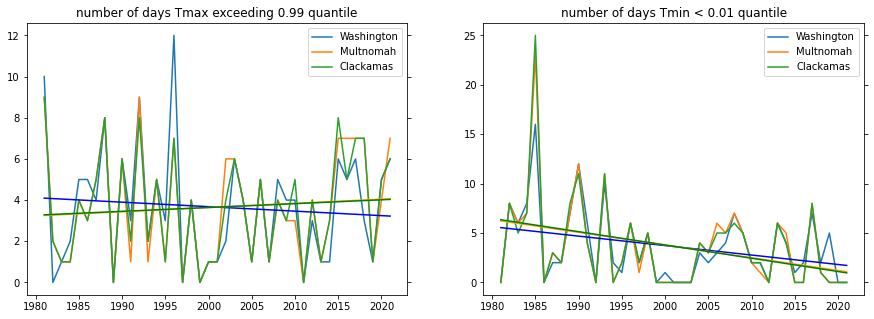

In [ ]:
p_value = 0.99
df_n_quantile(df_tmax, df_year, p_value, True)

fig, ax = plt.subplots(1,2,figsize=(15,5))
df_year.plot(title='number of days Tmax exceeding ' + str(p_value) + ' quantile',ax=ax[0])

plot_trend(df_year, ax[0])

p_value = 0.01
df_n_quantile(df_tmin, df_year, p_value, False)
df_year.plot(title='number of days Tmin < ' + str(p_value) + ' quantile',ax=ax[1])

plot_trend(df_year, ax[1])

### The number of days precipitation > 99th percentile and annual number of dry days¶



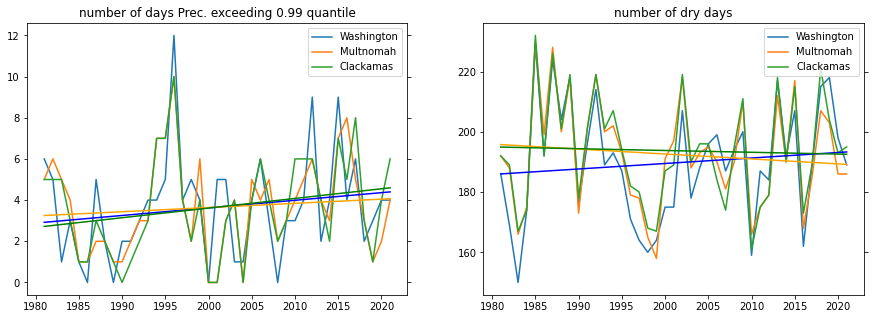

In [ ]:
p_value = 0.99
df_n_quantile(df_prec, df_year, p_value, True)

fig, ax = plt.subplots(1,2,figsize=(15,5))
df_year.plot(title='number of days Prec. exceeding ' + str(p_value) + ' quantile',ax=ax[0])

plot_trend(df_year, ax[0])

p_value = 0.0
df_n_quantile(df_prec, df_year, p_value, False)

df_year.plot(title='number of dry days',ax=ax[1])

plot_trend(df_year, ax[1])

### Annual Maximum and Mean Tmax

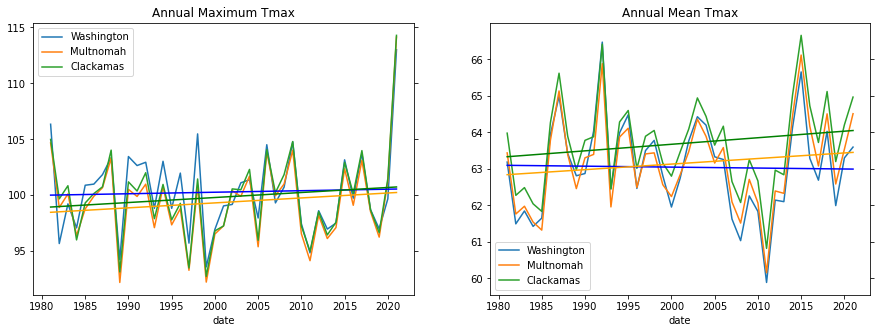

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
df_max = df_tmax[[name_col[3],name_col[4],name_col[5]]].groupby(lambda x: x.year).max()
df_max.plot(title='Annual Maximum Tmax',ax=ax[0]);
plot_trend(df_max, ax[0])

df_max = df_tmax[[name_col[3],name_col[4],name_col[5]]].groupby(lambda x: x.year).mean()
df_max.plot(title='Annual Mean Tmax',ax=ax[1])
plot_trend(df_max, ax[1])

### Annual minumum and Mean Tmin

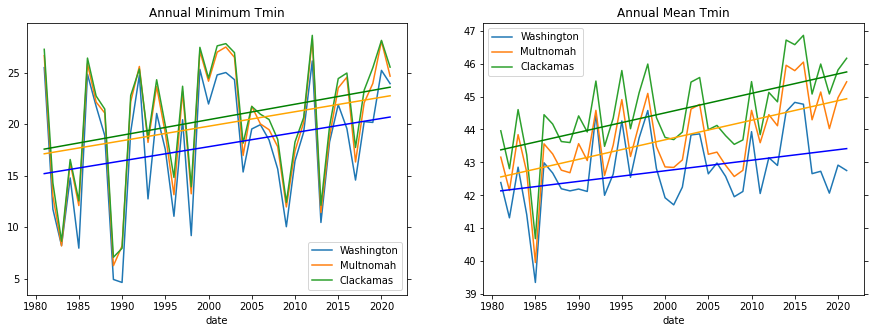

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
df_min = df_tmin[[name_col[3],name_col[4],name_col[5]]].groupby(lambda x: x.year).min()
df_min.plot(title='Annual Minimum Tmin',ax=ax[0]);
plot_trend(df_min, ax[0])

df_min = df_tmin[[name_col[3],name_col[4],name_col[5]]].groupby(lambda x: x.year).mean()
df_min.plot(title='Annual Mean Tmin',ax=ax[1])
plot_trend(df_min, ax[1])

### Annual Maximum and Mean Precipitation

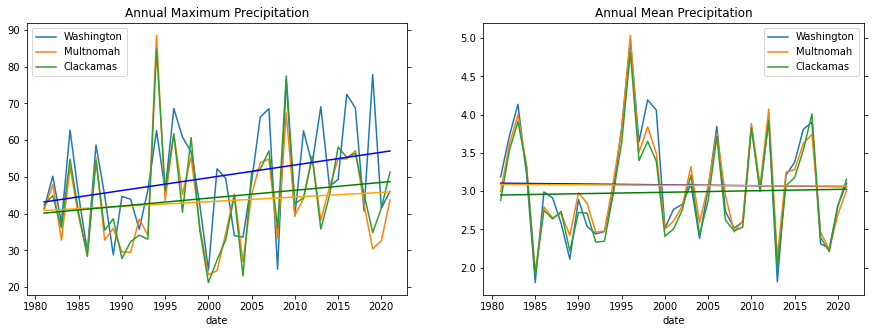

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
df_pr = df_prec[[name_col[3],name_col[4],name_col[5]]].groupby(lambda x: x.year).max()
df_pr.plot(title='Annual Maximum Precipitation',ax=ax[0]);
plot_trend(df_pr, ax[0])

df_min = df_prec[[name_col[3],name_col[4],name_col[5]]].groupby(lambda x: x.year).mean()
df_min.plot(title='Annual Mean Precipitation',ax=ax[1])
plot_trend(df_min, ax[1])

### Annual mean Tmax of 4 seasons

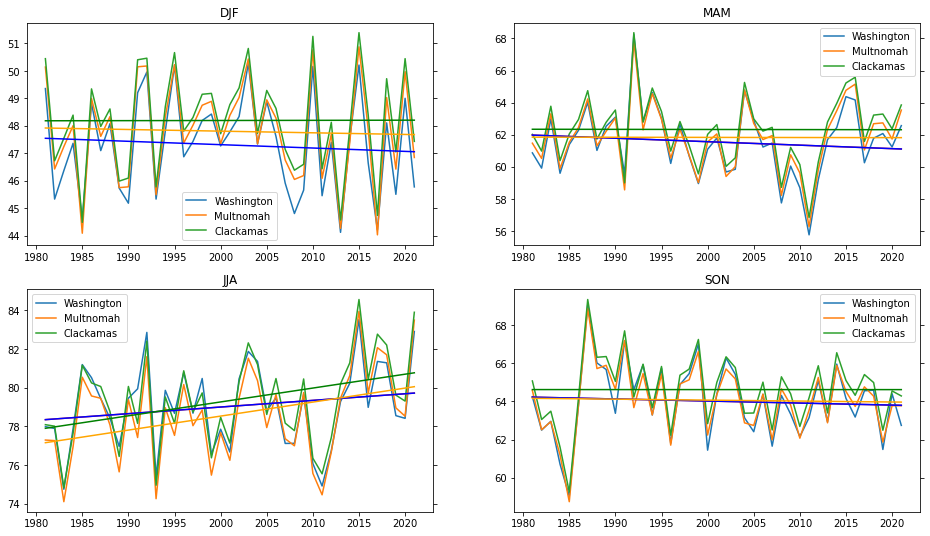

In [ ]:
plot_seasonal_ts(df_tmax, 'mean')

### Annual Maximum Tmax of 4 seasons

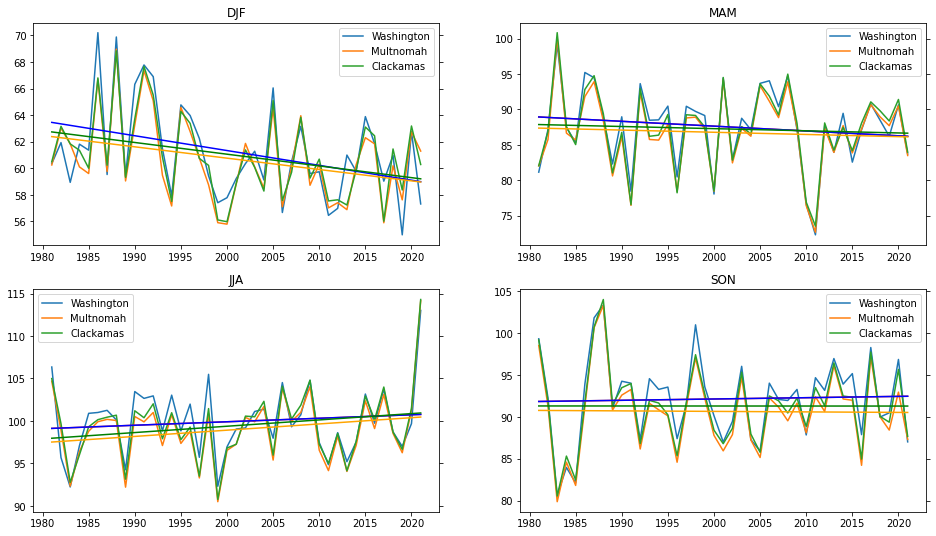

In [ ]:
plot_seasonal_ts(df_tmax,'max')

### Annual minimum Tmin of 4 seasons

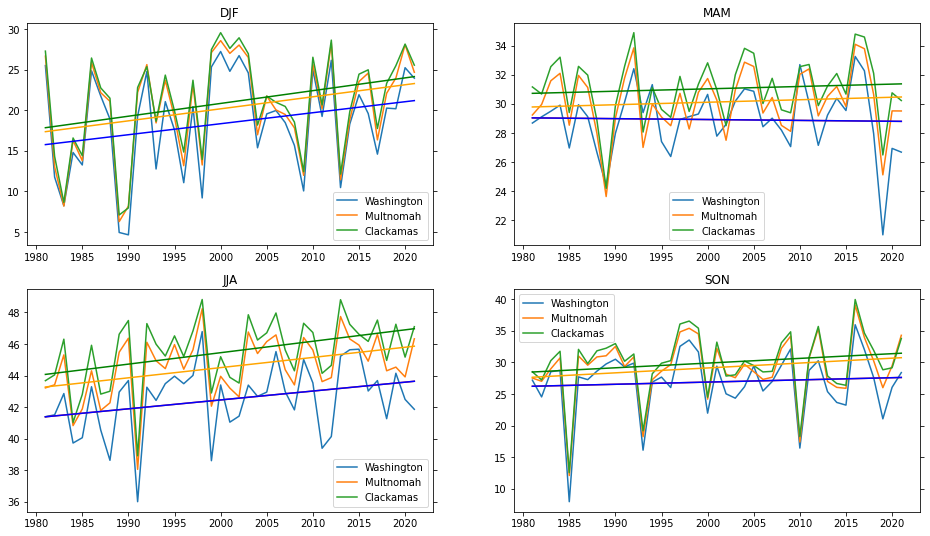

In [ ]:
plot_seasonal_ts(df_tmin, 'min') 

### Annual mean Tmin of 4 seasons

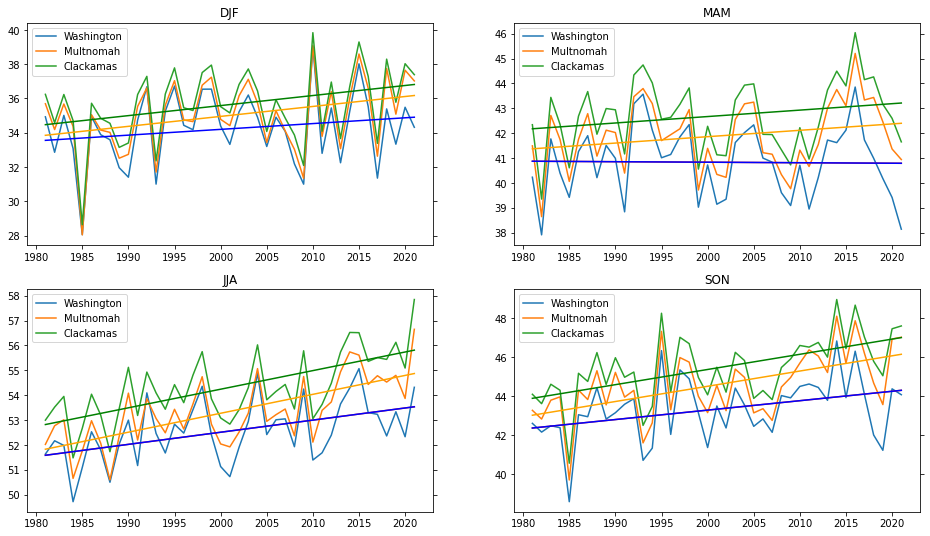

In [ ]:
plot_seasonal_ts(df_tmin,'mean') 

### Annual mean precipitation of 4 seasons

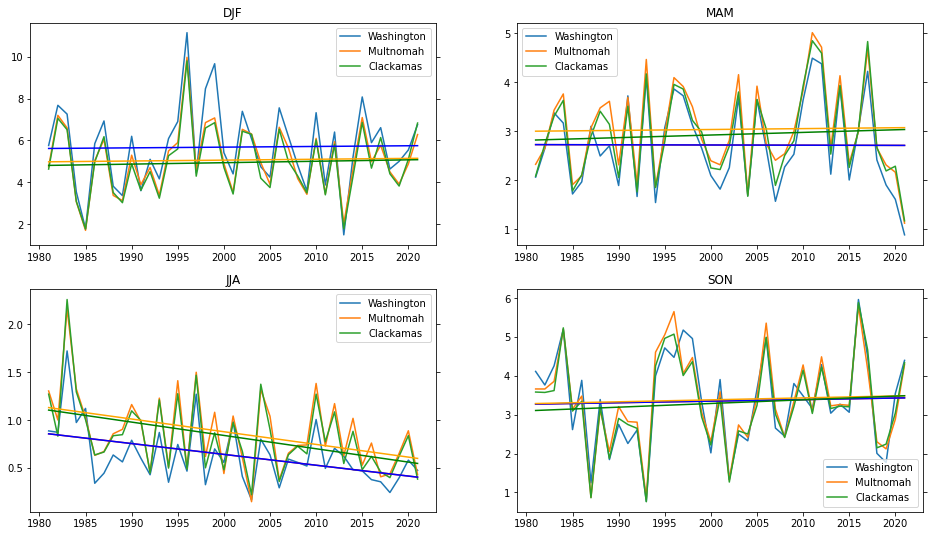

In [ ]:
plot_seasonal_ts(df_prec, 'mean')

### Annual maximum precipitation of 4 seasons

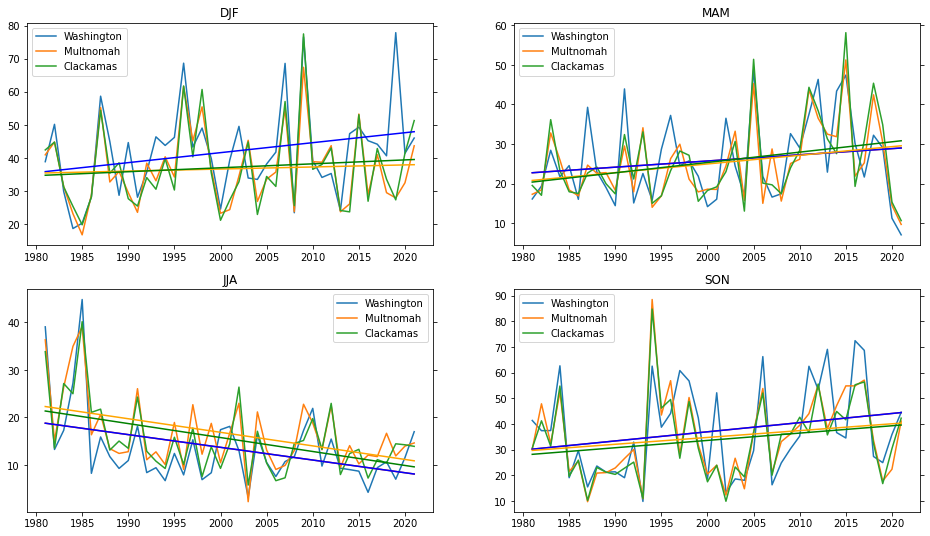

In [ ]:
plot_seasonal_ts(df_prec, 'max')

### Annual number of days for  Tmax>P99 and Tmin<P1 and Precip>P99 for each season please?

1


KeyError: ignored

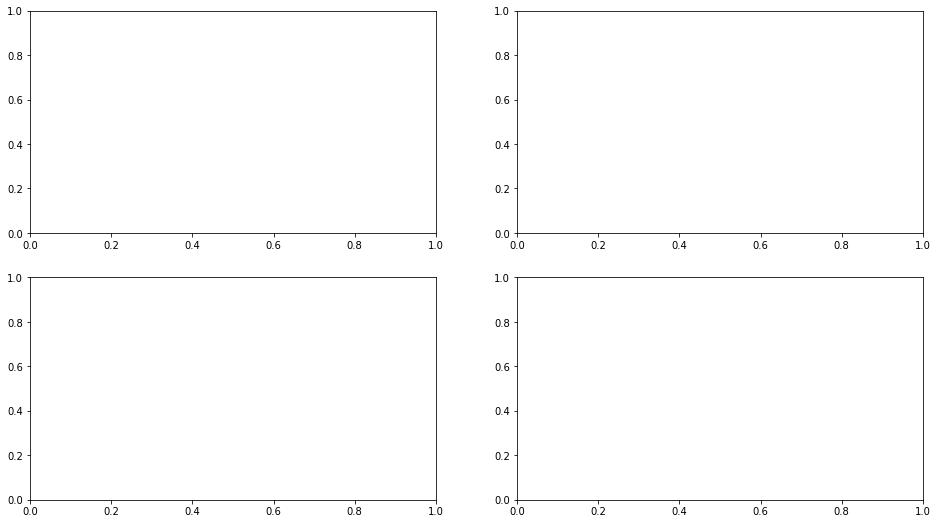

In [ ]:
p_value = 0.99
df_n_quantile(df_tmax, df_year, p_value, True)

df_year['year'] = df_year.index
#print(df_year['year'])
plot_seasonal_ts(df_year, 'mean')


